# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [3]:
# TODO: Install any packages that you might need

In [4]:
# TODO: Import any packages that you might need

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [15]:
import os
import json
import boto3
from tqdm import tqdm
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

# Exploratory Data Analysis on Amazon Bin Image Dataset

### Metadata
Metadata files are JSON files containing some information about the items in the dataset.



In [3]:
!aws s3 cp --no-sign-request s3://aft-vbi-pds/metadata/1.json -

{
    "BIN_FCSKU_DATA": {},
    "EXPECTED_QUANTITY": 0,
    "image_fname": "1.jpg"
}

we only work with image_fname and EXPECTED_QUANTITY fields of the metadata

In [4]:
!aws s3 ls --no-sign-request s3://aft-vbi-pds/metadata/ --summarize > metadatalist

In [5]:
!tail metadatalist

2017-01-14 01:59:16       4529 99993.json
2017-01-14 01:59:16       4529 99994.json
2017-01-14 01:59:16       3740 99995.json
2017-01-14 01:59:16        864 99996.json
2017-01-14 01:59:16       2132 99997.json
2017-01-14 01:59:16       2770 99998.json
2017-01-14 01:59:16       1658 99999.json

Total Objects: 536435
   Total Size: 1098414519


#### obs:
The dataset contains 536,435 JSON metadata files.

### Data

In [6]:
!aws s3 ls --no-sign-request s3://aft-vbi-pds/bin-images/ --summarize > list
!tail list

2017-01-14 02:03:14      80192 99993.jpg
2017-01-14 02:03:14     104201 99994.jpg
2017-01-14 02:03:14     103665 99995.jpg
2017-01-14 02:03:14      58212 99996.jpg
2017-01-14 02:03:14      39300 99997.jpg
2017-01-14 02:03:14      36076 99998.jpg
2017-01-14 02:03:14      35218 99999.jpg

Total Objects: 536435
   Total Size: 30466377489


The dataset has 536,435 JPEG files in total in alignment with metadata files. Due to file naming rules, they can be divided into three categories:

- 1~4 digit: 1.jpg ~ 1200.jpg: 1200
- 5-digit: 00001.jpg ~ 99999.jpg: 99,999
- 6-digit: 100000.jpg ~ 535234.jpg: 435,235

In [9]:
def download_metadata():
    s3_client = boto3.client('s3')

    local_directory = 'metadata_1_1200'
    s3_directory = 'metadata'
    if not os.path.exists(local_directory):
        os.makedirs(local_directory)
    for i in tqdm(range(1, 1201)):
        file_name = "%s.json" % i
        s3_client.download_file('aft-vbi-pds', os.path.join(s3_directory, file_name), os.path.join(local_directory, file_name))
download_metadata()

100%|██████████| 1200/1200 [01:39<00:00, 12.10it/s]


In [12]:
values = []
directory = "metadata_1_1200"
for i in range(1, 1201):
    filename = "%s/%s.json" % (directory, i)
    with open(filename, "r") as f:
        data = json.load(f)
        n = data['EXPECTED_QUANTITY']
        values.append(n)

df = pd.DataFrame({'quantity': values})

<Figure size 600x800 with 0 Axes>

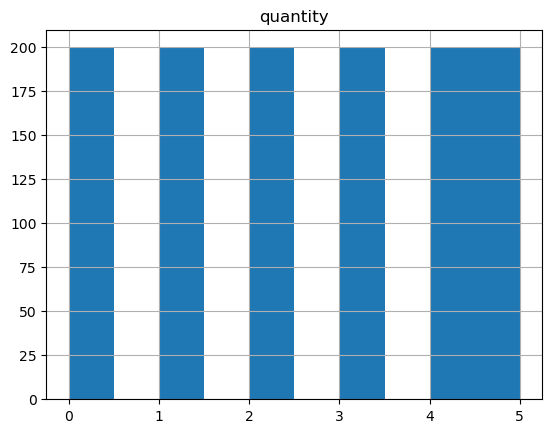

In [31]:
plt.figure(figsize=(6,8))
df.hist()
plt.show()

#### Obs:
we can see, Group 1 is distributed evenly and has no imbalance between different quantities.

#### Distrubtion of class objects

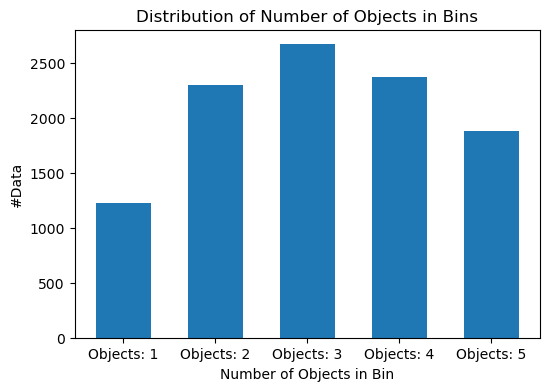

In [29]:
with open('file_list.json', 'r') as f:
    d=json.load(f)
    

num_objects = [("Objects: " + k) for k in d.keys()]
values = [len(v) for v in d.values()]
  
fig, ax =  plt.subplots(figsize = (6, 4))
 
# creating the bar plot
ax.bar(num_objects, values, width = 0.6)

plt.xlabel("Number of Objects in Bin")
plt.ylabel("#Data")
plt.title("Distribution of Number of Objects in Bins")
plt.show()

# Preprocessing data

In [3]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:56<00:00, 10.55it/s]


100%|██████████| 2299/2299 [03:43<00:00, 10.29it/s]


100%|██████████| 2666/2666 [04:17<00:00, 10.35it/s]


100%|██████████| 2373/2373 [03:49<00:00, 10.35it/s]


100%|██████████| 1875/1875 [02:55<00:00, 10.69it/s]


In [36]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.tuner import (IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner)
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from PIL import Image
import shutil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [37]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [38]:
print(f"Default Bucket: {bucket}")
print(f"RoleArn: {role}")

Default Bucket: sagemaker-us-east-1-631985645395
RoleArn: arn:aws:iam::631985645395:role/service-role/AmazonSageMaker-ExecutionRole-20230807T144975


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [7]:
!aws s3 cp --no-sign-request s3://aft-vbi-pds/metadata/1.json -

{
    "BIN_FCSKU_DATA": {},
    "EXPECTED_QUANTITY": 0,
    "image_fname": "1.jpg"
}

In [8]:
!aws s3 ls --no-sign-request s3://aft-vbi-pds/metadata/ --summarize > list_data

In [9]:
!tail list_data

2017-01-14 01:59:16       4529 99993.json
2017-01-14 01:59:16       4529 99994.json
2017-01-14 01:59:16       3740 99995.json
2017-01-14 01:59:16        864 99996.json
2017-01-14 01:59:16       2132 99997.json
2017-01-14 01:59:16       2770 99998.json
2017-01-14 01:59:16       1658 99999.json

Total Objects: 536435
   Total Size: 1098414519


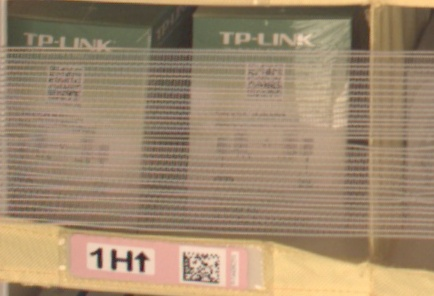

In [32]:
import argparse
import numpy as np
import json
import logging
import os
import io
import sys
import matplotlib.pyplot as plt
import requests
from PIL import Image
import json

request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/559.jpg" }
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [11]:
#TODO: Perform any data cleaning or data preprocessing
from os import listdir
import os.path

count = 0
dataset_folder = 'train_data'

for file in os.listdir(dataset_folder):
    path = os.path.join(dataset_folder, file)
    number = len(os.listdir(path))
    print(f'Number of images with the label of "{file}": {number}')
    count += number
print(f'\nNumber of images in total: {count}')
total_images = count

Number of images with the label of "4": 2373
Number of images with the label of "2": 2299
Number of images with the label of "1": 1228
Number of images with the label of "5": 1875
Number of images with the label of "3": 2666

Number of images in total: 10441


In [12]:
# We are preparing our folders for train-test-validation split

train_test_val_split = ['train','valid','test']
labels =['1','2','3','4','5']

new_folder_dataset = 'amazon_images'

if not os.path.exists(new_folder_dataset):
    os.makedirs(new_folder_dataset)
    print(f'Successfully created a new folder named "{new_folder_dataset}"')

for folder in train_test_val_split:
    
    if not os.path.exists(os.path.join(new_folder_dataset, folder)):
        os.makedirs(os.path.join(new_folder_dataset, folder))
        print(f'Successfully created the path of "{os.path.join(new_folder_dataset, folder)}"')
        
    for label in labels:
        path = os.path.join(new_folder_dataset, folder, label)
        if not os.path.exists(path):
            os.makedirs(path)
            print(f'Successfully created the path of "{path}"')
            
# Useful method to delete a folder with files inside
# import shutil
# shutil.rmtree('bin_images')

Successfully created a new folder named "amazon_images"
Successfully created the path of "amazon_images/train"
Successfully created the path of "amazon_images/train/1"
Successfully created the path of "amazon_images/train/2"
Successfully created the path of "amazon_images/train/3"
Successfully created the path of "amazon_images/train/4"
Successfully created the path of "amazon_images/train/5"
Successfully created the path of "amazon_images/valid"
Successfully created the path of "amazon_images/valid/1"
Successfully created the path of "amazon_images/valid/2"
Successfully created the path of "amazon_images/valid/3"
Successfully created the path of "amazon_images/valid/4"
Successfully created the path of "amazon_images/valid/5"
Successfully created the path of "amazon_images/test"
Successfully created the path of "amazon_images/test/1"
Successfully created the path of "amazon_images/test/2"
Successfully created the path of "amazon_images/test/3"
Successfully created the path of "amazon_i

In [13]:
train_ratio = 0.8
test_ratio = (1 - train_ratio)/2
validation_ratio = (1 - train_ratio)/2
    
for label in os.listdir(dataset_folder):
    
    path = os.path.join(dataset_folder, label)
    dataset = (os.listdir(path))
    dataset_len = len((os.listdir(path)))
    
    train_len = round(dataset_len * train_ratio)
    train_list = dataset[:train_len]
    
    test_len = round(dataset_len * test_ratio)
    test_list = dataset[train_len:train_len+test_len]
    
    validation_len = round(dataset_len * validation_ratio)
    validation_list = dataset[train_len+test_len:]
    
    list_dictionary = {'train': train_list,
                       'test': test_list,
                       'valid': validation_list}
    
    print("Label number is: " + label)
    
    for folder in train_test_val_split:
#         print('Resizing of the images is starting...')
        print(f'Saving the files to {new_folder_dataset}/{folder} folder\n')
        for file in list_dictionary[folder]:
            path = os.path.join(dataset_folder, label, file)
            if 'ipynb' not in path:
                
# This can be used to resize images in this step

#                 img = Image.open(path).convert('RGB')
#                 resized_img = img.resize((224,224),Image.BILINEAR)
#                 image_path = os.path.join(new_folder_dataset, folder, label, file)     
#                 resized_img.save(image_path)

                copy = os.path.join(dataset_folder, label, file)
                paste = os.path.join(new_folder_dataset, folder, label)
                shutil.copy(copy, paste)

print('\nSaving process has been completed.')

Label number is: 4
Saving the files to amazon_images/train folder

Saving the files to amazon_images/valid folder

Saving the files to amazon_images/test folder

Label number is: 2
Saving the files to amazon_images/train folder

Saving the files to amazon_images/valid folder

Saving the files to amazon_images/test folder

Label number is: 1
Saving the files to amazon_images/train folder

Saving the files to amazon_images/valid folder

Saving the files to amazon_images/test folder

Label number is: 5
Saving the files to amazon_images/train folder

Saving the files to amazon_images/valid folder

Saving the files to amazon_images/test folder

Label number is: 3
Saving the files to amazon_images/train folder

Saving the files to amazon_images/valid folder

Saving the files to amazon_images/test folder


Saving process has been completed.


In [ ]:
bucket = sagemaker_session.default_bucket()
prefix = 'capstone_project'
# !aws s3 cp amazon_images s3://aws-udacity-capstone/ --recursive #alternative
session = sagemaker.session.Session()
inputs = session.upload_data(path='amazon_images', bucket=bucket, key_prefix=prefix)

In [ ]:
print(f"input spec (in this case, just an S3 path): {inputs}")

In [ ]:
type(inputs)

In [33]:
train = "s3://sagemaker-us-east-1-631985645395/capstone_project/train/"
valid = "s3://sagemaker-us-east-1-631985645395/capstone_project/valid/"
test = "s3://sagemaker-us-east-1-631985645395/capstone_project/test/"
# train = inputs + "/train/"
# valid = inputs + "/valid/"
# test = inputs + "/test/"
print(train)

s3://sagemaker-us-east-1-631985645395/capstone_project/train/


## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [44]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values


#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.01),
    "batch_size": CategoricalParameter([64, 128]),
    "epochs": IntegerParameter(4, 6),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test Loss: ([+-]?[0-9\\.]+)"}]

In [45]:
#TODO: Create your training estimator
estimator = PyTorch(
    entry_point="hpo-mobilenet.py",
    role=role,
    py_version='py3',
    framework_version="1.8",
    instance_count=1,
    instance_type= "ml.g4dn.xlarge",
    # 'ml.m5.2xlarge',
    )

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [46]:
# TODO: Fit your estimator
# tuner.fit({"training": inputs}, wait=True) # TODO: Remember to include your data channels
tuner.fit(
    {
        "training": train, 
        "valid": valid,
        "test": test,
    }, 
    wait=True
)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
....................................................................................................................................................................................................................................................................................................!


In [47]:
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-08-16 03:21:55 Starting - Found matching resource for reuse
2023-08-16 03:21:55 Downloading - Downloading input data
2023-08-16 03:21:55 Training - Training image download completed. Training in progress.
2023-08-16 03:21:55 Uploading - Uploading generated training model
2023-08-16 03:21:55 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'epochs': '6',
 'lr': '0.007197852980662563',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-08-16-02-58-33-190"',
 'sagemaker_program': '"hpo-vgg16.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-631985645395/pytorch-training-2023-08-16-02-58-33-190/source/sourcedir.tar.gz"'}

In [48]:
best_hyperparameters ={
    "batch_size": int(best_estimator.hyperparameters()["batch_size"].replace('"', "")),
    "epochs": best_estimator.hyperparameters()["epochs"],
    "lr": best_estimator.hyperparameters()["lr"],
}

In [49]:
best_hyperparameters

{'batch_size': 128, 'epochs': '6', 'lr': '0.007197852980662563'}

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [ ]:
#TODO: Create your hyperparameter search space

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

In [ ]:
# TODO: Find the best hyperparameters

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [50]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [51]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train-mobilenet.py",
    framework_version="1.6",
    py_version="py36",
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    hyperparameters=best_hyperparameters,
    rules=rules,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
)

In [52]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [53]:
# TODO: Plot a debugging output.
estimator.fit(
    {
        "training": train, 
        "valid": valid,
        "test": test,
    }, 
    wait=True
)

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-08-16-03-24-25-858


2023-08-16 03:24:26 Starting - Starting the training job...
2023-08-16 03:24:56 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-08-16 03:25:56 Downloading - Downloading input data...
2023-08-16 03:26:16 Training - Downloading the training image...
2023-08-16 03:26:56 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-16 03:26:54,276 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-16 03:26:54,278 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-08-16 03:26:54,289 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-08-16 03:26:54,291 sagemaker_pytorch_container.training INFO  

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [54]:
from sagemaker.pytorch import PyTorchModel

model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-631985645395/pytorch-training-2023-08-16-03-24-25-858/output/model.tar.gz


In [31]:
# TODO: Run an prediction on the endpoint
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()
# this class ImgPredictor is a subclass created from the Predictor class and is used to send image data to the endpoint
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )

In [40]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
# TODO: Deploy your model to an endpoint
pytorch_model = PyTorchModel(
    model_data=model_data, 
    role=role, 
    entry_point='inference.py',
    py_version="py36",
    framework_version="1.8",
    predictor_cls = ImgPredictor
)

predictor = pytorch_model.deploy(initial_instance_count=1, 
                                 instance_type="ml.m5.2xlarge")
# TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-631985645395/pytorch-training-2023-08-07-12-04-55-671/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-631985645395/pytorch-inference-2023-08-07-15-27-26-855/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-08-07-15-27-31-870
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-08-07-15-27-32-647
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-08-07-15-27-32-647


----!

In [41]:
# TODO: Run an prediction on the endpoint
from PIL import Image
import io
import os
import numpy as np

import requests
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/777.jpg"}
              
img_bytes = requests.get(request_dict['url']).content
# type(img_bytes)

response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
# application/json
import numpy as np
np.argmax(response)

2

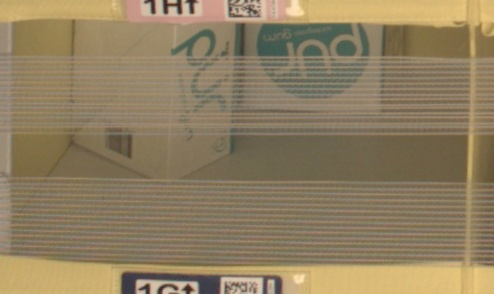

In [42]:
Image.open(io.BytesIO(img_bytes))

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances